<div class="alert alert-block alert-info">
__Name__: heidelburg_clonal_structure<br/>
__Description__: Examine relationship between phenotypes and clonal structure <br/>
__Author__: Matthew Whiteside matthew dot whiteside at canada dot ca<br/>
__Date__: Nov 2, 2017<br/>
__TODO__:<br/>
</div>

In [32]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
import numpy as np
import pandas as pd
from sklearn.externals import joblib
from hpsklearn import HyperoptEstimator, random_forest, gradient_boosting, xgboost_classification
from hyperopt import tpe
from sklearn.metrics import f1_score, classification_report
import os
os.chdir('../pangenome')
import utils
import classify
import config

In [34]:
# Examine AMR distribution

# Load
metadatafile = '/media/poolhouse/workspace/l_amr/data/NML/heidelburg_james/SVM_Heidelberg_AMR_Data.csv'
df = pd.read_table(metadatafile)
amr_list = ["AMC","AMP","AZM","FOX","CRO","TIO","NAL","STR","SOX","TCY","SXT"]
amr = df[amr_list].values
sample_index = df["SRA_Accession"]

# Insufficient data
valid = ~np.apply_along_axis(lambda c: sum(c == 0) < 30 or sum(c == 1) < 30, 0, amr)
amr = amr[:,valid]
amr_list = np.array(amr_list)[valid]

# Correlated drugs
r = np.corrcoef(amr, rowvar=False)
ind = np.vstack(np.triu_indices_from(r,k=1)).T
highlycorrelated = ind[r[ind[:,0],ind[:,1]] > .98]

for hc in highlycorrelated:
    print("Correlated Pair: {}:{}, {}:{} r: {}".format(hc[0], amr_list[hc[0]], hc[1], amr_list[hc[1]], r[hc[0],hc[1]]))

removecols = [0,3,4]
keepcols = np.setdiff1d(np.arange(amr.shape[1]),removecols)
amr = amr[:,keepcols]
amr_list = amr_list[keepcols]



Correlated Pair: 0:AMC, 2:FOX r: 0.990981798647073
Correlated Pair: 0:AMC, 3:CRO r: 0.9819995077842689
Correlated Pair: 0:AMC, 4:TIO r: 0.990981798647073
Correlated Pair: 2:FOX, 3:CRO r: 0.9909359678703817
Correlated Pair: 2:FOX, 4:TIO r: 0.9999999999999999
Correlated Pair: 3:CRO, 4:TIO r: 0.9909359678703817


In [35]:
# Load pangenome

pangenomefiles = [
    '/media/poolhouse/workspace/l_amr/data/NML/heidelburg_james/panseq/percentIdentityCutoff90__fragmentationSize1000__coreGenomeThreshold180/pan_genome.txt',
    '/media/poolhouse/workspace/l_amr/data/NML/heidelburg_james/panseq/percentIdentityCutoff90__fragmentationSize500__coreGenomeThreshold180/pan_genome.txt',
    '/media/poolhouse/workspace/l_amr/data/NML/heidelburg_james/panseq/percentIdentityCutoff95__fragmentationSize1000__coreGenomeThreshold180/pan_genome.txt',
    '/media/poolhouse/workspace/l_amr/data/NML/heidelburg_james/panseq/percentIdentityCutoff95__fragmentationSize500__coreGenomeThreshold180/pan_genome.txt',
]

# Based on earlier performance comparison 90% identity with 1000 bp regions is best for 4 out of 5 drugs
pg, genome_index, locus_list = utils.read_panseq(pangenomefiles[0])

# Match amr and pangenome rows
row_ordering = np.argsort(sample_index)
amr = amr[row_ordering,]
sample_index = sample_index[row_ordering]
ndrugs = len(amr_list)
df = df.loc[row_ordering,:]
test_train_index = df["Dataset"].values

row_ordering2 = np.argsort(genome_index)
pg = pg[row_ordering2,]
genome_index = genome_index[row_ordering2]

if not np.all(sample_index == genome_index):
    raise Exception("Dataset mismatch")


In [36]:
# Save feature and response data
joblib.dump(amr, config.SH['amr'])
joblib.dump(amr_list, config.SH['amr_list'])
joblib.dump(sample_index, config.SH['sample_index'])
joblib.dump(pg, config.SH['pg'])
joblib.dump(locus_list, config.SH['locus_list'])
joblib.dump(test_train_index, config.SH['test_train_index'])

['/media/poolhouse/workspace/l_amr/data/NML/heidelburg_james/ml/test_train_index.jpkl']

CPU times: user 56.1 s, sys: 744 ms, total: 56.8 s
Wall time: 32.8 s


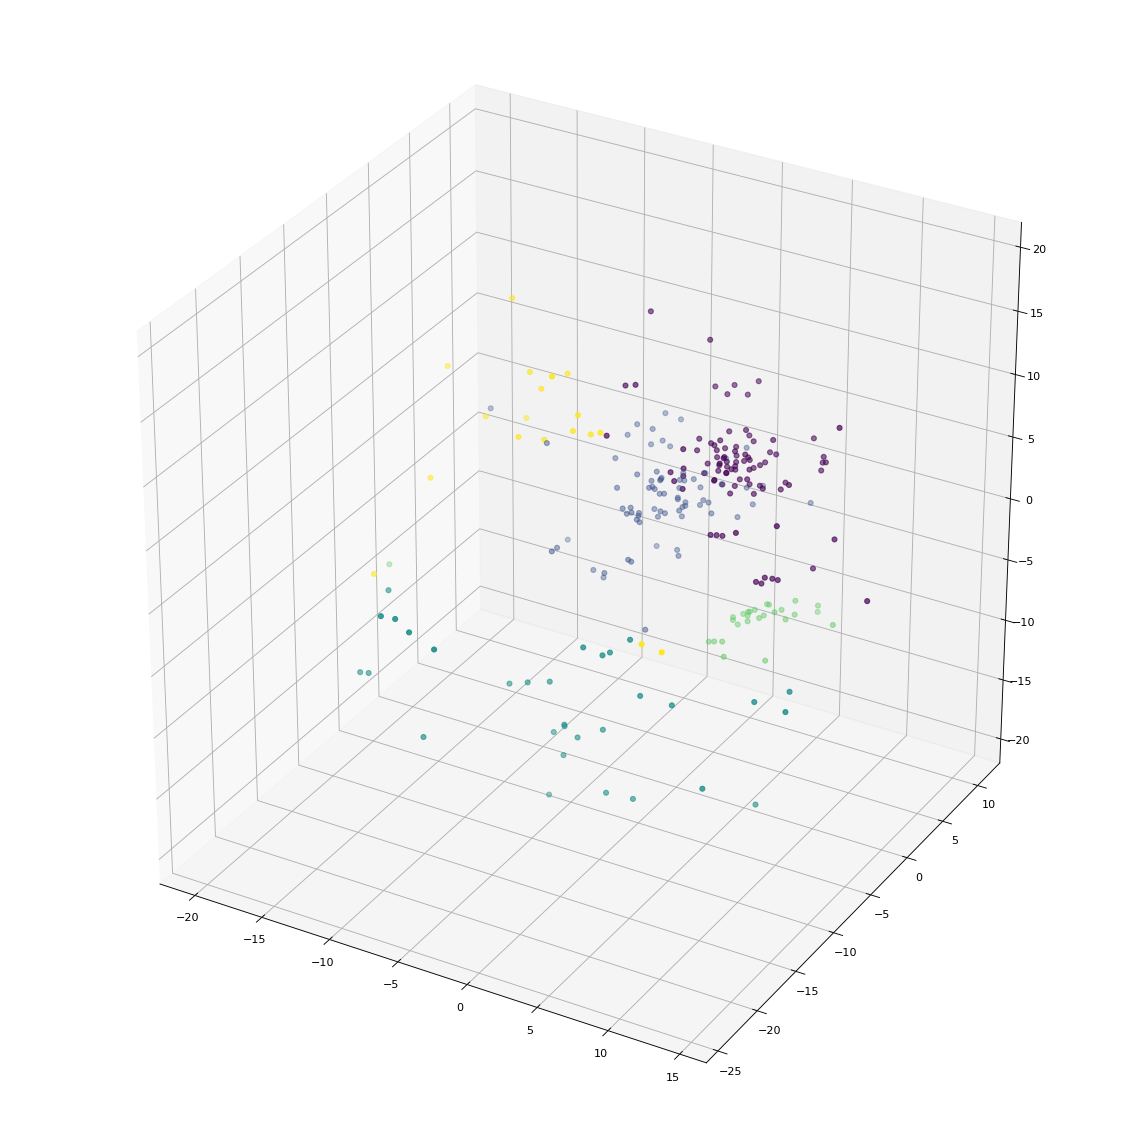

In [5]:
# Examine clonal structure & metadata associations
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

X = pg

# MDS decomposition for visualization
D = pairwise_distances(X, metric='euclidean')
mds =  MDS(n_components=3, random_state=3489, dissimilarity='precomputed', n_jobs=4)
D_mds3 = mds.fit_transform(D)
N = D_mds3.shape[0]

# Assign genomes to clonal groups/clusters based on pangenome distritribution
km = KMeans(n_clusters=5)
%time km.fit(X)
clonal_clusters = km.labels_.tolist()

fig = plt.figure(figsize=(14, 14), dpi= 80, facecolor='w', edgecolor='k')
ax = Axes3D(fig)
colours = clonal_clusters
ax.scatter(D_mds3[:, 0], D_mds3[:, 1], D_mds3[:, 2], c=colours)

plt.show()


In [6]:
# Check association between clonal clusters and phenotypes
import scipy as sp

df.loc[:,'cluster'] = pd.Series(clonal_clusters)

expdict = {}
clusters, cluster_counts = np.unique(clonal_clusters, return_counts=True)

aggfuncs = dict()
for a in amr_list:
    N1 = np.sum(df[a])

    aggfuncs[a] = lambda x: np.sum(x)
    expdict[a] = { c: N1/N*i for c, i in zip(clusters, cluster_counts) }
    
obsdf = df.groupby('cluster').agg(aggfuncs)
expdf = pd.DataFrame(expdict)

for a in amr_list:
    
    # Statistical significance of possible association
    print(a)
    print(sp.stats.stats.chisquare(obsdf[a], f_exp=expdf[a]).pvalue)

AMP
0.962211631901
FOX
0.285335061803
STR
0.451800331196
SOX
0.606994317401
TCY
0.726518812679


In [24]:
# Repeat with tree clades
from ete3 import Tree

# Load tree and root at midpoint
tree = Tree(config.SH['tree'])
R = tree.get_midpoint_outgroup()
tree.set_outgroup(R)

# Move down tree until desired number of clusters obtained
current_clusters = [tree]

while(len(current_clusters) < 30):
    
    # Split each non-leaf node at next level
    new_clusters = []
    for n in current_clusters:
        if n.is_leaf():
            new_clusters.append(n)
        else:
            new_clusters.extend(n.children)
            
    current_clusters = new_clusters
    
N = len(sample_index)
tree_clusters = np.empty(N)
tree_clusters[:] = np.NAN
c = 0
for n in current_clusters:
    if n.is_leaf():
        tree_clusters[sample_index == n.name] = c
    else:
        leaf_names = [ l.name for l in n.get_leaves() ]
        tree_clusters[np.in1d(sample_index, leaf_names)] = c
    c += 1
    
# Display cluster subtrees
i = 0
for c in current_clusters:
    print("\n\n\n~~~~CLUSTER TREE {}~~~~".format(i))
    print(c)
    i += 1




~~~~CLUSTER TREE 0~~~~

--SRR2407540



~~~~CLUSTER TREE 1~~~~

--SRR2407565



~~~~CLUSTER TREE 2~~~~

--SRR3664973



~~~~CLUSTER TREE 3~~~~

   /-SRR3665092
--|
   \-SRR3665074



~~~~CLUSTER TREE 4~~~~

   /-SRR3664914
--|
  |   /-SRR3665226
   \-|
      \-SRR3665232



~~~~CLUSTER TREE 5~~~~

--SRR2566926



~~~~CLUSTER TREE 6~~~~

--SRR3665171



~~~~CLUSTER TREE 7~~~~

   /-SRR3665009
--|
  |   /-SRR2407610
   \-|
     |   /-SRR2567185
      \-|
        |   /-SRR2407600
         \-|
            \-SRR2407601



~~~~CLUSTER TREE 8~~~~

   /-SRR2567174
--|
   \-SRR2567088



~~~~CLUSTER TREE 9~~~~

      /-SRR3665002
   /-|
  |  |   /-SRR3665260
  |   \-|
  |     |   /-SRR3664812
  |      \-|
  |         \-SRR2566948
  |
  |   /-SRR3664777
  |  |
--|  |            /-SRR3665023
  |  |         /-|
  |  |        |  |   /-SRR3665215
  |  |        |   \-|
  |  |      /-|     |   /-SRR3665070
  |  |     |  |      \-|
  |  |     |  |         \-SRR3665069
  |  |   /-|  |
  |  |  |  |   

In [25]:
df.loc[:,'tree_cluster'] = pd.Series(tree_clusters)

expdict = {}
clusters, cluster_counts = np.unique(tree_clusters, return_counts=True)

aggfuncs = dict()
for a in amr_list:
    N1 = np.sum(df[a])

    aggfuncs[a] = lambda x: np.sum(x)
    expdict[a] = { c: N1/N*i for c, i in zip(clusters, cluster_counts) }
    
obsdf = df.groupby('tree_cluster').agg(aggfuncs)
expdf = pd.DataFrame(expdict)

for a in amr_list:
    
    # Statistical significance of possible association
    print(a)
    print(sp.stats.stats.chisquare(obsdf[a], f_exp=expdf[a]).pvalue)

AMP
0.99742238567
FOX
0.887120480425
STR
0.918433739118
SOX
0.412452551147
TCY
0.890515190692


In [26]:
df

,SampleID,SRA_Accession,Serovar,Country,State/Province,CollectionYear,PrimarySourceCategory,SecondarySourceCategory,SampleType,AMC,...,CRO,TIO,NAL,STR,SOX,TCY,SXT,Dataset,cluster,tree_cluster
75,CVM N52006,SRR2407533,Heidelberg,United States,California,2014,Food,Chicken,Wing,0,...,0,0,0,1,1,1,0,Training,0,39.0
237,CVM N52019,SRR2407540,Heidelberg,United States,Colorado,2014,Food,Pork,NaN,0,...,0,0,1,1,1,1,1,Training,1,32.0
43,CVM N52028,SRR2407549,Heidelberg,United States,Minnesota,2014,Food,Chicken,Thigh,1,...,1,1,0,1,1,0,0,Training,2,16.0
59,CVM N52029,SRR2407550,Heidelberg,United States,Minnesota,2014,Food,Turkey,NaN,0,...,0,0,0,1,0,1,0,Training,0,39.0
214,CVM N52031,SRR2407552,Heidelberg,United States,Minnesota,2014,Food,Chicken,Breast,0,...,0,0,0,0,0,0,0,Validation,1,32.0
153,CVM N52032,SRR2407553,Heidelberg,United States,Missouri,2014,Food,Chicken,Leg,0,...,0,0,0,0,0,0,0,Validation,1,39.0
146,CVM N52044,SRR2407565,Heidelberg,United States,Oregon,2014,Food,Chicken,Leg,0,...,0,0,0,1,1,0,0,Validation,1,32.0
37,CVM N52046,SRR2407567,Heidelberg,United States,Oregon,2014,Food,Chicken,Breast,0,...,0,0,0,1,1,1,0,Training,0,39.0
53,CVM N53010,SRR2407587,Heidelberg,United States,California,2014,Food,Chicken,Breast,0,...,0,0,0,1,0,1,0,Training,0,39.0
196,CVM N53011,SRR2407588,Heidelberg,United States,California,2014,Food,Turkey,NaN,0,...,0,0,0,1,1,1,0,Validation,1,39.0


In [31]:
df["Dataset"].values

array(['Training', 'Training', 'Training', 'Training', 'Validation',
       'Validation', 'Validation', 'Training', 'Training', 'Validation',
       'Training', 'Training', 'Validation', 'Validation', 'Validation',
       'Validation', 'Training', 'Training', 'Validation', 'Validation',
       'Validation', 'Validation', 'Training', 'Validation', 'Training',
       'Validation', 'Training', 'Training', 'Training', 'Validation',
       'Validation', 'Validation', 'Training', 'Training', 'Training',
       'Validation', 'Validation', 'Validation', 'Training', 'Validation',
       'Validation', 'Validation', 'Validation', 'Validation', 'Training',
       'Training', 'Training', 'Validation', 'Training', 'Validation',
       'Validation', 'Training', 'Training', 'Training', 'Training',
       'Training', 'Training', 'Validation', 'Validation', 'Validation',
       'Training', 'Validation', 'Validation', 'Training', 'Validation',
       'Training', 'Validation', 'Training', 'Training', 'Val

In [37]:
amr_list

array(['AMP', 'FOX', 'STR', 'SOX', 'TCY'],
      dtype='<U3')